**Problem Startment**

ADR(adverse drug reactions) detection based on tweets posted by user through text classification.

In [0]:
# loading necessary libraries
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import re, string
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

In [0]:
#load the dataset
data = pd.read_csv("Data.csv")

In [6]:
data.head()

,UserId,TweetId,Tweet,ADR_label
0,10030778,413205,Intravenous azithromycin-induced ototoxicity.,1
1,10048291,528244,"Immobilization, while Paget's bone disease was...",1
2,10048291,361834,Unaccountable severe hypercalcemia in a patien...,1
3,10082597,292240,METHODS: We report two cases of pseudoporphyri...,1
4,10082597,467101,METHODS: We report two cases of pseudoporphyri...,1


In [7]:
#check for missing values
data.apply(lambda x: sum(x.isnull()))

UserId       0
TweetId      0
Tweet        0
ADR_label    0
dtype: int64

In [8]:
data.shape

(23516, 4)

In [9]:
#target column dist
(data.ADR_label.value_counts() / len(data))*100

0    70.989964
1    29.010036
Name: ADR_label, dtype: float64

In [1]:
import re 
import nltk 
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
corpus = []        
for i in range(len(data['Tweet'])):         
  review = re.sub('[^a-zA-Z]',' ',data['Tweet'][i])            
  review = review.lower()            
  review = review.split()            
  ps = PorterStemmer()            
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]            
  review = ' '.join(review)            
  corpus.append(review)

In [0]:
data['Corpus']=corpus

In [0]:
#target column = ADR_label
y = data.ADR_label
#splitting data into train & test as we don't have testing data.
X_train, X_test, y_train, y_test = train_test_split(data['Corpus'], y, test_size=0.2)

In [15]:
X_train

20309              toxic usual limit anticholinerg symptom
17544    follow widespread use gvo sever complic needl ...
16148    basal secretin stimul gastrin respons suppress...
13280    histolog cutan lesion show spongiosi infiltr e...
11401    report case morbidli obes labor parturi receiv...
                               ...                        
11490    hepatolithiasi uncommon western countri quit p...
5581     conclus case describ clinic signific increas i...
19836    three week later die clostridium septicum seps...
3818     background assess natur incid risk factor reti...
5837     anterior spinal arteri syndrom complic cervic ...
Name: Corpus, Length: 18812, dtype: object

In [16]:
#lengths of tweets
lens = X_train.str.len()
print("Mean length of Tweet: %.3f" % (lens.mean()))
print("Mean length of Tweet: %.3f" % (lens.std()))
print("Mean length of Tweet: %.3f" % (lens.max()))

Mean length of Tweet: 88.681
Mean length of Tweet: 42.777
Mean length of Tweet: 478.000


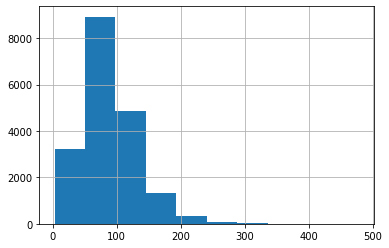

In [17]:
#distribution of lens
lens.hist();

In [0]:
#Here we'll be creating a bag of words representation
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [0]:
#We'll use ngrams and Tfidf for feature engineering.
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(X_train)
test_term_doc = vec.transform(X_test)

In [21]:
trn_term_doc,test_term_doc

(<18812x20552 sparse matrix of type '<class 'numpy.float64'>'
 	with 311214 stored elements in Compressed Sparse Row format>,
 <4704x20552 sparse matrix of type '<class 'numpy.float64'>'
 	with 72852 stored elements in Compressed Sparse Row format>)

In [0]:
#string converted to numbers for train data
x = trn_term_doc 
#string converted to numbers for test data
test_x = test_term_doc

In [0]:
target = ['ADR_label']

In [24]:
#trying first with LR and parameters taken from a kaggle kernel
lr_model = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
lr_model.fit(x,y_train)

[LibLinear]

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [25]:
#make predictions and check score
lr_predictions = lr_model.predict(test_x)
print(lr_model.score(test_x, y_test))

0.8903061224489796


In [26]:
#trying MultiNB
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(x, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [27]:
#make predictions and check score
mnb_predictions = mnb_model.predict(test_x)
print(mnb_model.score(test_x, y_test))

0.8618197278911565


In [0]:
#let's check auc score 
lr_auc = roc_auc_score(y_test, lr_predictions)
mnb_auc = roc_auc_score(y_test, mnb_predictions)

In [29]:
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('MultinomialNB: ROC AUC=%.3f' % (mnb_auc))

Logistic: ROC AUC=0.855
MultinomialNB: ROC AUC=0.801


In [0]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predictions)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test, mnb_predictions)

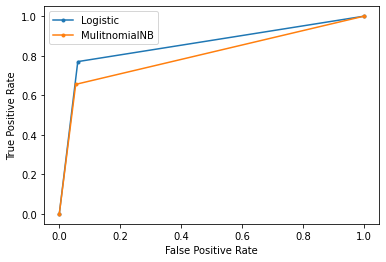

In [31]:
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(mnb_fpr, mnb_tpr, marker='.', label='MulitnomialNB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.803 auc=0.838
MultinomialNB: f1=0.733 auc=0.794


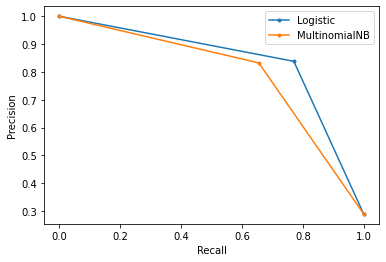

In [32]:
#calculating precision and recall for both models
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_predictions)
mnb_precision, mnb_recall, _ = precision_recall_curve(y_test, mnb_predictions)
lr_f1, lr_auc = f1_score(y_test, lr_predictions), auc(lr_recall, lr_precision)
mnb_f1, mnb_auc = f1_score(y_test, mnb_predictions), auc(mnb_recall, mnb_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('MultinomialNB: f1=%.3f auc=%.3f' % (mnb_f1, mnb_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.plot(mnb_recall, mnb_precision, marker='.', label='MultinomialNB')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

As we saw, Logistic Regression performed good above. So we'll try to hypertune it and try to achieve better accuracy

In [0]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
clf = GridSearchCV(lr_model, hyperparameters, cv=5, verbose=0)

In [35]:
best_model = clf.fit(x,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [36]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


In [37]:
cv_predictions = best_model.predict(test_x)
print(best_model.score(test_x, y_test))

0.8943452380952381


In [0]:
cv_auc = roc_auc_score(y_test, cv_predictions)

In [0]:
cv_fpr, cv_tpr, _ = roc_curve(y_test, cv_predictions)

In [40]:
print('Tuned_Logistic: ROC AUC=%.3f' % (cv_auc))

Tuned_Logistic: ROC AUC=0.868


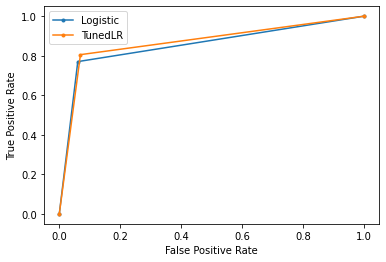

In [41]:
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(cv_fpr, cv_tpr, marker='.', label='TunedLR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.803 auc=0.838
TunedCV: f1=0.816 auc=0.844


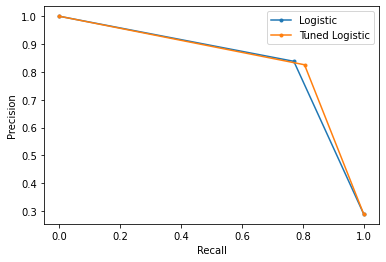

In [42]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_predictions)
cv_precision, cv_recall, _ = precision_recall_curve(y_test, cv_predictions)
lr_f1, lr_auc = f1_score(y_test, lr_predictions), auc(lr_recall, lr_precision)
cv_f1, cv_auc = f1_score(y_test, cv_predictions), auc(cv_recall, cv_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('TunedCV: f1=%.3f auc=%.3f' % (cv_f1, cv_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.plot(cv_recall, cv_precision, marker='.', label='Tuned Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next, I'll try to process the text in a better way as now I've only removed punctuation and stopwords. Also we'll try to implement a Neural Network using Keras.